## Note: Les définitions des fonctions et les imports en fin du notebook

### Loading data

In [4]:
log_file_path = "../data/access_light.log"
data = load_data(log_file_path)

### Q1) Nombre de lignes

In [5]:
%%time
print("** Nombre de lignes du fichier: {}".format(data.count()))

** Nombre de lignes du fichier: 1999
CPU times: user 9.28 ms, sys: 8.19 ms, total: 17.5 ms
Wall time: 1.83 s


### Q2) Nombre d'IP uniques loggées 

In [6]:
%%time
print("** Le nombre d'IP uniques loggées: {}".format(data.map(lambda log: log.remote_host).distinct().count()))

** Le nombre d'IP uniques loggées: 357
CPU times: user 27.1 ms, sys: 4.68 ms, total: 31.8 ms
Wall time: 601 ms


## From rdd to Dataframe

In [7]:
%%time
logs_sdf = data.map(lambda log: (log.remote_host, log.request_time, parse_ua(log.headers_in['User-Agent'])))\
                .toDF(["host", "request_time", "browserFamily"])

CPU times: user 17.2 ms, sys: 4.18 ms, total: 21.4 ms
Wall time: 2.2 s


In [8]:
# tiny check
logs_sdf.show(1)

+---------------+-------------------+-------------+
|           host|       request_time|browserFamily|
+---------------+-------------------+-------------+
|109.169.248.247|2015-12-12 18:25:11|      Firefox|
+---------------+-------------------+-------------+
only showing top 1 row



## Q3) Nombre de requetes par IP

In [9]:
logs_sdf.select("host", "request_time").groupBy("host").count().select("count").agg(avg(col("count"))\
                                                        .alias("average number of requests by IP")).show()

+--------------------------------+
|average number of requests by IP|
+--------------------------------+
|               5.599439775910364|
+--------------------------------+



## Q4) DATA VIZ

### a) Répartition des navigateurs

In [10]:
browsers, counts_bins = getBrowserHist(logs_sdf)

In [11]:
NB_TOP_BROWSERS = 15
args_top = np.argsort(-1*np.array(counts_bins))[:NB_TOP_BROWSERS]
browsers_top = np.array(browsers)[args_top]
counts_bins_top = np.array(counts_bins)[args_top]

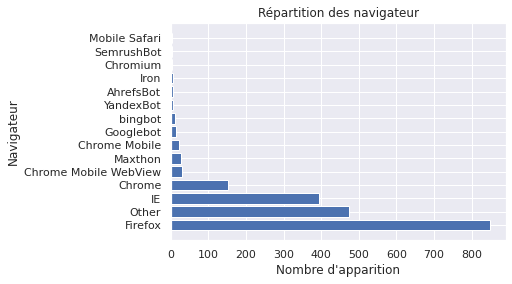

In [12]:
plot_browsers_bar(browsers_top, counts_bins_top, logscale=False, save=True)

### b) Nombre de visiteurs par jour de la semaine et par heure

In [13]:
dataframe_dataviz = getHourlyHostsPerWeekday(logs_sdf)

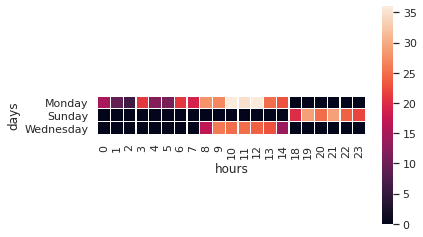

In [14]:
ax = sns.heatmap(dataframe_dataviz, linewidths=.3, square=True)

## Q5)

In [15]:
# Sessionize the logs
SESSION_TIME = 30
user_session_id = sessionizeByTime(logs_sdf, session_time=SESSION_TIME)

## Analytics by sessions

In [16]:
user_session_id.select(dayofmonth('request_time').alias('day'),month('request_time')\
                .alias('month'),year('request_time').alias('year'), 'user_session_id' )\
                .groupBy('year', 'month',"day").agg(countDistinct('user_session_id').alias('sessionsDistinct'))\
                .agg(avg("sessionsDistinct").alias('Average number of sessions per day')).show()

+----------------------------------+
|Average number of sessions per day|
+----------------------------------+
|                               1.0|
+----------------------------------+



In [17]:
user_session_id.select("host", "user_session_id").groupBy("host").agg(countDistinct("user_session_id")\
                .alias("nb_sessions_per_host")).agg(avg('nb_sessions_per_host')\
                .alias("average number of sessions per host")).show()

+-----------------------------------+
|average number of sessions per host|
+-----------------------------------+
|                                1.0|
+-----------------------------------+



In [18]:
request_by_session = user_session_id.select("host", "user_session_id", "request_time").groupBy("host","user_session_id")\
                .count().cache()

In [19]:
request_by_session.select("count").agg(avg("count").alias("Average number of requests by session")).show()

+-------------------------------------+
|Average number of requests by session|
+-------------------------------------+
|                    5.599439775910364|
+-------------------------------------+



# ================================================================================================================

# Import libraries

In [1]:
import re

import sys
import os
import re
import datetime
from pyspark.sql import Row
from pyspark import SparkContext
from user_agents import parse

from pyspark.sql.functions import col, avg
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import dayofweek, hour, countDistinct, dayofmonth
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from apachelogs import LogParser


from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.sql.functions import unix_timestamp, when, year, month, dayofmonth
from pyspark.sql.functions import sum as _sum

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Functions

In [3]:
# Defining the logs parser and the format of each line
parser = LogParser("%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\"")

def load_data(source_path):
    """Funtion that loads data and filters empty rows
       Out:  PythonRDD
    """
    return sc.textFile(source_path).filter(lambda x: x is not u'').map(lambda row: parser.parse(row[:-4])).cache()

def parse_ua(ua_string):
    """Function that parse user agent and return the browserFamily
        Out: String
    """
    # parse library cannot parse None
    if ua_string is None:
        ua_string = ""

    parsed_string = parse(ua_string)

    output = parsed_string.browser.family
    
    if output is None:
        output = 'Unknown'
    return output

def getBrowserHist(logs_sdf):
    """
    Function that return for each browserFaily his number off apparition
    Out: List, List
    """
    
    browser_hist = logs_sdf.select("browserFamily").groupBy("browserFamily").count().collect()
    
    browsers = [browser for (browser,_)  in browser_hist]
    counts_bins = [count for (_,count)  in browser_hist]
    #logscale_counts_bins = [np.log(count) for (_,count)  in browser_hist]
    
    return browsers, counts_bins

def plot_browsers_bar(browsers, counts_bins, logscale=False, save=False):
    """
    Plot the histogram of browserFamily, and save it if 'save' is set to True
    Out: None
    """
    
    plt.barh(browsers, counts_bins, log=logscale)
    plt.title("Répartition des navigateur")
    plt.xlabel("Nombre d'apparition")
    plt.ylabel("Navigateur")
    
    if save == True:
        plt.savefig("../output/repartitionDesNavigateurs.pdf")
        
        
def getHourlyHostsPerWeekday(logs_sdf):
    
    """
    Return the number of hosts by hour for each weekday
    Out: dataframe
    """
    
    # mapping id to day (Example: 0 => Monday, 1 => Tuesday ...)
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

    
    hosts_by_day_hour = logs_sdf.select(dayofweek('request_time').alias('dayofweek'), hour('request_time')\
                                    .alias('hour'), 'host').cache()
    
    hosts_by_day_hour_unique = hosts_by_day_hour.groupBy('dayofweek', 'hour').agg(countDistinct("host")\
                                    .alias('countHosts')).sort("dayofweek", "hour").cache()
    
    days = [weekDays[_day-1] for (_day,_,_) in hosts_by_day_hour_unique.collect()]
    hours = [_hour for (_,_hour,_) in hosts_by_day_hour_unique.collect()]
    daily_hourly_hosts = [_host for (_,_,_host) in hosts_by_day_hour_unique.collect()]
    
    dataframe_dataviz = pd.DataFrame(list(zip(days, hours, daily_hourly_hosts)), columns=["days", "hours"\
                                , "daily_hourly_hosts"])\
                                .pivot("days","hours", "daily_hourly_hosts").fillna(0)
        
    return dataframe_dataviz


def sessionizeByTime(logs_sdf, session_time=30):
    
    """
    Compute the user sessions according to the session_time
    Out: dataframe
    """
    last_event = logs_sdf.select("host", "request_time").withColumn("last_event", lag('request_time')\
                                                    .over(Window.partitionBy('host').orderBy('request_time')))
    lag_in_day = last_event.withColumn('lag_in_day', (unix_timestamp('request_time') - unix_timestamp('last_event'))/3600)
    new_session = lag_in_day.withColumn('is_new_session', when( col('lag_in_day') > SESSION_TIME , 1).otherwise(0))
    user_session_id = new_session.withColumn("user_session_id", _sum('is_new_session')\
                                 .over(Window.partitionBy('host').orderBy('request_time'))).cache()
    return user_session_id.select('host', 'request_time', 'user_session_id')

    